## Complex Network Analysis: Premier League - Basic Functions

This notebook implements basic functions to load Premier League data, create a complex network for a specific season, and visualize this network.

In [566]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import community as co
import seaborn as sns
from typing import List, Optional
from collections import defaultdict

# Ignore some common warnings for a cleaner display
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning) # For newer pandas and networkx versions

### 1. Data Loading

Function to load the dataset.

In [567]:
def load_data(file_path):
    """
    Loads the dataset from a CSV file.
    
    Args:
        file_path (str): The path to the CSV file.
        
    Returns:
        pandas.DataFrame: The loaded DataFrame, or None if the file is not found.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        print(f"Dataset shape: {df.shape}")
        # Convert MatchDate to datetime if not already
        if 'MatchDate' in df.columns:
             df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

### 2. Seasonal Network Creation

Function to create an `nx.MultiDiGraph` network for a given season. The edges represent the defined metrics (using original Italian keys):
- **"Gol"**: Total goal difference of team A against team B.
- **"Tiri efficaci"**: Shooting accuracy ((ShotsOnTarget / Shots) * 100) of team A against team B.
- **"Aggressività"**: Aggressiveness score (Fouls + YellowCards + 3*RedCards) of team A against team B.
- **"Controllo"**: Control score (Corners + Shots) of team A against team B.

In [568]:
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning)

def normalize_val(val, min_val, max_val, target_range=(0, 1)):
    """Normalizes a value using Min-Max scaling to a target range."""
    if max_val == min_val:
        # Avoid division by zero, return midpoint if no variance
        return (target_range[0] + target_range[1]) / 2
    
    normalized_0_1 = (val - min_val) / (max_val - min_val)
    return normalized_0_1 * (target_range[1] - target_range[0]) + target_range[0]
    
def create_epl_network(df: pd.DataFrame, season: str = None, start_year: int = None, end_year: int = None) -> nx.DiGraph:
    """
    Creates a DIRECTED graph network where each edge (SourceTeam -> TargetTeam)
    represents the aggregated performance/action of the SourceTeam AGAINST the TargetTeam,
    along with the calculated differences in performance between Source and Target.

    Edge attributes will only reflect the SourceTeam's actions (e.g., goals scored by Source,
    fouls committed by Source) and the overall differences (Source vs Target).
    To get TargetTeam's actions against Source, you'd look at the reverse edge (TargetTeam -> SourceTeam).

    Args:
        df (pandas.DataFrame): The complete match DataFrame.
        season (str, optional): A specific season to analyze (e.g., '2016/17').
                                Takes precedence over start_year/end_year if both are provided.
                                Defaults to None.
        start_year (int, optional): The starting year of the season range (e.g., 2014 for '2014/15').
                                    Defaults to None.
        end_year (int, optional): The ending year of the season range (e.g., 2017 for '2016/17').
                                  Defaults to None.

    Returns:
        nx.DiGraph: The directed graph, or None if the data to process is empty.
    """
    
    df_to_process = df.copy()
    current_scope_name = "the entire dataset"

    if season:
        df_to_process = df[df['Season'] == season].copy()
        current_scope_name = f"season {season}"
    elif start_year is not None and end_year is not None:
        if not (isinstance(start_year, int) and isinstance(end_year, int)):
            print("Error: start_year and end_year must be integers.")
            return None
        if start_year > end_year:
            print("Error: start_year cannot be greater than end_year.")
            return None

        seasons_in_range = []
        for year in range(start_year, end_year + 1):
            next_year_suffix = str(year + 1)[-2:]
            seasons_in_range.append(f"{year}/{next_year_suffix}")
        
        df_to_process = df[df['Season'].isin(seasons_in_range)].copy()
        current_scope_name = f"seasons from {start_year}/{str(start_year+1)[-2:]} to {end_year}/{str(end_year+1)[-2:]}"
    
    if df_to_process.empty:
        print(f"No data found for {current_scope_name}.")
        return None

    cols_to_fill = ['FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShots', 'AwayShots',
                    'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners',
                    'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards',
                    'HomeRedCards', 'AwayRedCards']
    for col in cols_to_fill:
        if col in df_to_process.columns:
            df_to_process[col] = pd.to_numeric(df_to_process[col], errors='coerce').fillna(0)
        else:
            print(f"Warning: Critical column '{col}' not found in the dataset for {current_scope_name}. Cannot proceed.")
            return None

    # stats_cache ora memorizza le statistiche aggregate per OGNI DIREZIONE
    # Per (ht, at), conterrà le statistiche di HT contro AT e le statistiche di AT contro HT
    # Questo è necessario per calcolare le differenze che richiedono entrambe le informazioni
    # Questo NON è una duplicazione, ma l'aggregazione di informazioni per una data coppia direzionale.
    directional_stats_agg = defaultdict(lambda: {
        'goals_scored_by_source': 0, 'goals_scored_by_target': 0, # Gol segnati dalla SORGENTE, gol segnati dalla DESTINAZIONE
        'sot_by_source': 0, 'sot_by_target': 0,
        'total_shots_by_source': 0, 'total_shots_by_target': 0,
        'fouls_by_source': 0, 'fouls_by_target': 0,
        'yc_by_source': 0, 'yc_by_target': 0,
        'rc_by_source': 0, 'rc_by_target': 0,
        'corners_by_source': 0, 'corners_by_target': 0,
        'matches_played': 0 # Quante volte Source ha giocato contro Target (da Source's perspective)
    })

    for _, match in df_to_process.iterrows():
        ht = match['HomeTeam']
        at = match['AwayTeam']

        # HOME TEAM -> AWAY TEAM (HT è SOURCE, AT è TARGET)
        directional_stats_agg[(ht, at)]['goals_scored_by_source'] += match['FullTimeHomeGoals']
        directional_stats_agg[(ht, at)]['goals_scored_by_target'] += match['FullTimeAwayGoals'] # Gol che AT ha fatto a HT
        directional_stats_agg[(ht, at)]['sot_by_source'] += match['HomeShotsOnTarget']
        directional_stats_agg[(ht, at)]['sot_by_target'] += match['AwayShotsOnTarget']
        directional_stats_agg[(ht, at)]['total_shots_by_source'] += match['HomeShots']
        directional_stats_agg[(ht, at)]['total_shots_by_target'] += match['AwayShots']
        directional_stats_agg[(ht, at)]['fouls_by_source'] += match['HomeFouls']
        directional_stats_agg[(ht, at)]['fouls_by_target'] += match['AwayFouls']
        directional_stats_agg[(ht, at)]['yc_by_source'] += match['HomeYellowCards']
        directional_stats_agg[(ht, at)]['yc_by_target'] += match['AwayYellowCards']
        directional_stats_agg[(ht, at)]['rc_by_source'] += match['HomeRedCards']
        directional_stats_agg[(ht, at)]['rc_by_target'] += match['AwayRedCards']
        directional_stats_agg[(ht, at)]['corners_by_source'] += match['HomeCorners']
        directional_stats_agg[(ht, at)]['corners_by_target'] += match['AwayCorners']
        directional_stats_agg[(ht, at)]['matches_played'] += 1

        # AWAY TEAM -> HOME TEAM (AT è SOURCE, HT è TARGET)
        directional_stats_agg[(at, ht)]['goals_scored_by_source'] += match['FullTimeAwayGoals']
        directional_stats_agg[(at, ht)]['goals_scored_by_target'] += match['FullTimeHomeGoals'] # Gol che HT ha fatto a AT
        directional_stats_agg[(at, ht)]['sot_by_source'] += match['AwayShotsOnTarget']
        directional_stats_agg[(at, ht)]['sot_by_target'] += match['HomeShotsOnTarget']
        directional_stats_agg[(at, ht)]['total_shots_by_source'] += match['AwayShots']
        directional_stats_agg[(at, ht)]['total_shots_by_target'] += match['HomeShots']
        directional_stats_agg[(at, ht)]['fouls_by_source'] += match['AwayFouls']
        directional_stats_agg[(at, ht)]['fouls_by_target'] += match['HomeFouls']
        directional_stats_agg[(at, ht)]['yc_by_source'] += match['AwayYellowCards']
        directional_stats_agg[(at, ht)]['yc_by_target'] += match['HomeYellowCards']
        directional_stats_agg[(at, ht)]['rc_by_source'] += match['AwayRedCards']
        directional_stats_agg[(at, ht)]['rc_by_target'] += match['HomeRedCards']
        directional_stats_agg[(at, ht)]['corners_by_source'] += match['AwayCorners']
        directional_stats_agg[(at, ht)]['corners_by_target'] += match['HomeCorners']
        directional_stats_agg[(at, ht)]['matches_played'] += 1

    all_teams_in_scope = pd.concat([df_to_process['HomeTeam'], df_to_process['AwayTeam']]).unique()
    G = nx.DiGraph()
    G.add_nodes_from(all_teams_in_scope)

    # Raccogliamo i valori per la normalizzazione.
    # Abbiamo bisogno di min/max per gli attributi direzionali della SORGENTE
    all_goals_scored_by_source = []
    all_aggressiveness_by_source = []
    all_shot_accuracy_by_source = []
    all_control_by_source = []

    # E anche per le DIFFERENZE (che possono essere negative o positive)
    all_goals_diff = []
    all_aggressiveness_diff = []
    all_shot_accuracy_diff = []
    all_control_diff = []

    processed_edges_data = {}
    for (source_team, target_team), agg_stats in directional_stats_agg.items():
        if source_team == target_team:
            continue
        
        # --- RAW METRICS FOR SOURCE TEAM'S ACTION AGAINST TARGET TEAM ---
        current_goals_scored = agg_stats['goals_scored_by_source']
        current_agg_by_source = agg_stats['fouls_by_source'] + agg_stats['yc_by_source'] + 3 * agg_stats['rc_by_source']
        current_sa_by_source = (agg_stats['sot_by_source'] / agg_stats['total_shots_by_source']) if agg_stats['total_shots_by_source'] > 0 else 0.0
        current_ctrl_by_source = agg_stats['corners_by_source'] + agg_stats['total_shots_by_source']

        # --- CALCULATED DIFFERENCES (Source's performance relative to Target's performance against Source) ---
        # A positive difference means SourceTeam performed better in that metric compared to TargetTeam's performance against Source.
        goals_diff = current_goals_scored - agg_stats['goals_scored_by_target']
        aggressiveness_diff = current_agg_by_source - (agg_stats['fouls_by_target'] + agg_stats['yc_by_target'] + 3 * agg_stats['rc_by_target'])
        
        # Shot accuracy difference: (Source's SA - Target's SA)
        sa_of_target = (agg_stats['sot_by_target'] / agg_stats['total_shots_by_target']) if agg_stats['total_shots_by_target'] > 0 else 0.0
        shot_accuracy_diff = current_sa_by_source - sa_of_target

        # Control difference: (Source's Control - Target's Control)
        ctrl_of_target = agg_stats['corners_by_target'] + agg_stats['total_shots_by_target']
        control_diff = current_ctrl_by_source - ctrl_of_target


        processed_edges_data[(source_team, target_team)] = {
            # Raw totals (actions of source_team against target_team)
            'goals_scored': current_goals_scored,
            'aggressiveness_committed': current_agg_by_source,
            'shot_accuracy': current_sa_by_source,
            'control': current_ctrl_by_source,
            
            # Raw Differences (from source_team's perspective relative to target)
            'goals_diff': goals_diff,
            'aggressiveness_diff': aggressiveness_diff,
            'shot_accuracy_diff': shot_accuracy_diff,
            'control_diff': control_diff,

            'matches_played': agg_stats['matches_played']
        }

        # Collect values for min-max normalization ranges
        all_goals_scored_by_source.append(current_goals_scored)
        all_aggressiveness_by_source.append(current_agg_by_source)
        all_shot_accuracy_by_source.append(current_sa_by_source)
        all_control_by_source.append(current_ctrl_by_source)
        
        all_goals_diff.append(goals_diff)
        all_aggressiveness_diff.append(aggressiveness_diff)
        all_shot_accuracy_diff.append(shot_accuracy_diff)
        all_control_diff.append(control_diff)
    
    # Calculate global min/max for normalization
    min_goals_scored, max_goals_scored = (min(all_goals_scored_by_source), max(all_goals_scored_by_source)) if all_goals_scored_by_source else (0,0)
    min_agg_by_source, max_agg_by_source = (min(all_aggressiveness_by_source), max(all_aggressiveness_by_source)) if all_aggressiveness_by_source else (0,0)
    min_sa_by_source, max_sa_by_source = (min(all_shot_accuracy_by_source), max(all_shot_accuracy_by_source)) if all_shot_accuracy_by_source else (0,0)
    min_ctrl_by_source, max_ctrl_by_source = (min(all_control_by_source), max(all_control_by_source)) if all_control_by_source else (0,0)

    min_goals_diff, max_goals_diff = (min(all_goals_diff), max(all_goals_diff)) if all_goals_diff else (0,0)
    min_agg_diff, max_agg_diff = (min(all_aggressiveness_diff), max(all_aggressiveness_diff)) if all_aggressiveness_diff else (0,0)
    min_sa_diff, max_sa_diff = (min(all_shot_accuracy_diff), max(all_shot_accuracy_diff)) if all_shot_accuracy_diff else (0,0)
    min_ctrl_diff, max_ctrl_diff = (min(all_control_diff), max(all_control_diff)) if all_control_diff else (0,0)


    # Add edges to the graph with all calculated attributes
    for (source_team, target_team), stats in processed_edges_data.items():
        # Normalized totals (actions of source_team against target_team)
        goals_scored_norm = normalize_val(stats['goals_scored'], min_goals_scored, max_goals_scored)
        agg_committed_norm = normalize_val(stats['aggressiveness_committed'], min_agg_by_source, max_agg_by_source)
        sa_norm = normalize_val(stats['shot_accuracy'], min_sa_by_source, max_sa_by_source)
        ctrl_norm = normalize_val(stats['control'], min_ctrl_by_source, max_ctrl_by_source)

        # Normalized Differences (range 0-1, sign retained)
        goals_diff_norm = normalize_val(stats['goals_diff'], min_goals_diff, max_goals_diff)
        agg_diff_norm = normalize_val(stats['aggressiveness_diff'], min_agg_diff, max_agg_diff)
        sa_diff_norm = normalize_val(stats['shot_accuracy_diff'], min_sa_diff, max_sa_diff)
        ctrl_diff_norm = normalize_val(stats['control_diff'], min_ctrl_diff, max_ctrl_diff)
        
        G.add_edge(source_team, target_team,
                   # Raw totals (actions of source_team against target_team)
                   goals_scored=stats['goals_scored'],
                   aggressiveness_committed=stats['aggressiveness_committed'],
                   shot_accuracy=stats['shot_accuracy'],
                   control=stats['control'],
                   
                   # Normalized totals (actions of source_team against target_team)
                   goals_scored_norm=goals_scored_norm,
                   aggressiveness_committed_norm=agg_committed_norm,
                   shot_accuracy_norm=sa_norm,
                   control_norm=ctrl_norm,
                   
                   # Raw Differences
                   goals_diff=stats['goals_diff'],
                   aggressiveness_diff=stats['aggressiveness_diff'],
                   shot_accuracy_diff=stats['shot_accuracy_diff'],
                   control_diff=stats['control_diff'],

                   # Normalized Differences (range 0-1, sign retained)
                   goals_diff_norm=goals_diff_norm,
                   aggressiveness_diff_norm=agg_diff_norm,
                   shot_accuracy_diff_norm=sa_diff_norm,
                   control_diff_norm=ctrl_diff_norm,
                   
                   # Absolute Normalized Differences (range 0-1, always positive)
                   # Represents the magnitude of the difference, regardless of direction.
                   goals_diff_norm_abs=abs(goals_diff_norm - 0.5) * 2, # Re-normalize to 0-1 for absolute values
                   aggressiveness_diff_norm_abs=abs(agg_diff_norm - 0.5) * 2,
                   shot_accuracy_diff_norm_abs=abs(sa_diff_norm - 0.5) * 2,
                   control_diff_norm_abs=abs(ctrl_diff_norm - 0.5) * 2,

                   matches_played=stats['matches_played']
        )
        
    print(f"Network created for {current_scope_name} with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

## Normalize network

### 3. Network Visualization

Basic function to visualize the network. For complex `MultiDiGraph` graphs, visualizing all information simultaneously can be confusing. This function optionally allows visualizing edges related to a single metric.

In [569]:
def visualize_network(G, season_name, metric_to_display=None, file_name=None):
    """
    Visualizes the seasonal network.

    Args:
        G (networkx.MultiDiGraph): The graph to visualize.
        season_name (str): The name of the season (for the plot title).
        metric_to_display (str, optional): The specific metric to display (e.g., "goals").
                                           If None, tries to draw all edges (can be cluttered).
        file_name (str, optional): If provided, saves the image to the specified path.
    """
    if G is None:
        print("Graph is None, cannot visualize.")
        return

    plt.figure(figsize=(14, 10))
    pos = nx.circular_layout(G) # Circular layout, good for leagues
    
    title = f"Premier League Network - Season {season_name}"
    graph_to_draw = G
    edge_labels_to_draw = None

    if metric_to_display:
        # Create a simple graph (DiGraph) with only edges of the specified metric
        G_metric = nx.DiGraph()
        G_metric.add_nodes_from(G.nodes())
        
        # Iterate with keys=True to get the actual edge key
        for u, v, edge_key, data in G.edges(keys=True, data=True):
            if edge_key == metric_to_display: # Check against edge_key directly
                G_metric.add_edge(u, v, weight=data['weight'])
        
        if not G_metric.edges():
            print(f"No edges found for metric '{metric_to_display}'. Displaying base node layout.")
            # Draw only nodes if no edges for the metric
            nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.9)
            nx.draw_networkx_labels(G, pos, font_size=9)
        else:
            graph_to_draw = G_metric
            title += f" - Metric: {metric_to_display}"
            # Prepare weight labels for edges of the selected metric
            edge_labels_to_draw = {(u, v): f"{d['weight']:.2f}" for u, v, d in G_metric.edges(data=True)}
            # Draw nodes, edges, and labels for the specific metric graph
            nx.draw_networkx_nodes(graph_to_draw, pos, node_size=2000, node_color='skyblue', alpha=0.9)
            nx.draw_networkx_labels(graph_to_draw, pos, font_size=9)
            nx.draw_networkx_edges(graph_to_draw, pos, arrowstyle='->', arrowsize=15, width=1.5, edge_color='teal')
            if edge_labels_to_draw:
                nx.draw_networkx_edge_labels(graph_to_draw, pos, edge_labels=edge_labels_to_draw, font_size=7)

    else: # No specific metric, draw the full MultiDiGraph
        nx.draw_networkx_nodes(graph_to_draw, pos, node_size=2000, node_color='skyblue', alpha=0.9)
        nx.draw_networkx_labels(graph_to_draw, pos, font_size=9)
        # Basic drawing for MultiDiGraph (can be cluttered)
        # Drawing all edges with arrows. For better distinction, you might color by 'key'
        nx.draw_networkx_edges(graph_to_draw, pos, arrowstyle='->', arrowsize=15, 
                               edge_color='gray', alpha=0.5, connectionstyle='arc3,rad=0.1')
        print("Displaying all edges for MultiDiGraph. For clarity, consider specifying 'metric_to_display'.")
    
    plt.title(title, fontsize=15)
    plt.axis('off')
    
    if file_name:
        try:
            plt.savefig(file_name, format='PNG', dpi=300)
            print(f"Plot saved as {file_name}")
        except Exception as e:
            print(f"Error saving plot: {e}")
    plt.show()

In [570]:
def calculate_and_print_centralities(graph: nx.DiGraph, metric: str, threshold: Optional[float] = None, keep_above: bool = True):
    """
    Calculates and prints various centrality measures for a given DiGraph and a specific metric.
    The graph can be optionally filtered by a threshold on the '{metric}_diff_norm_abs'
    attribute before centrality calculations.

    Args:
        graph (nx.DiGraph): The networkx graph to analyze. Edges represent actions of
                            source -> target, with attributes like '{metric}_scored_norm'
                            and '{metric}_diff_norm_abs'.
        metric (str): The base name of the metric to use for centrality calculations
                      (e.g., 'goals', 'aggressiveness', 'shot_accuracy', 'control').
                      
                      Expected weight attributes on edges:
                      - For out-strength, eigenvector, and distance-based for Betweenness/Closeness:
                        'goals_scored_norm' (for 'goals'),
                        'aggressiveness_committed_norm' (for 'aggressiveness'),
                        'shot_accuracy_norm' (for 'shot_accuracy'),
                        'control_norm' (for 'control').
        threshold (float, optional): If provided, only edges where '{metric}_diff_norm_abs'
                                     is greater than or equal to this threshold will be included
                                     in the centrality calculations. Defaults to None (no filtering).
        keep_above (bool, optional): If True, keeps edges where weight >= threshold. If False, keeps edges where weight <= threshold.

    Returns:
        dict: A dictionary containing all calculated centrality measures.
    """
    centrality_scores = {}

    print(f"\n--- Calculating Centrality Measures for metric: {metric} (Threshold: {threshold if threshold is not None else 'None'}) ---")

    if graph.number_of_nodes() == 0:
        print(f"Warning: Input graph for metric '{metric}' is empty. Skipping centrality calculations.")
        return {
            'in_degree': {}, 'out_degree': {},
            'in_strength': {}, 'out_strength': {},
            'betweenness': {}, 'closeness': {}, 'eigenvector': {}
        }
    
    # Determina l'attributo per il filtraggio (sempre _diff_norm_abs per la soglia)
    filter_weight_attr = f"{metric}_diff_norm_abs"
    filtered_graph = nx.DiGraph()
    filtered_graph.add_nodes_from(graph.nodes(data=True)) # Aggiungi tutti i nodi, anche isolati

    edges_retained_count = 0
    if threshold is not None:
        filter_condition_str = ">= threshold" if keep_above else "<= threshold"
        print(f"Applying filter for '{metric}' with threshold {filter_condition_str} on '{filter_weight_attr}'.")
        for u, v, data in graph.edges(data=True):
            if filter_weight_attr in data and data[filter_weight_attr] is not None:
                metric_value = data[filter_weight_attr]
                if (keep_above and metric_value >= threshold) or \
                   (not keep_above and metric_value <= threshold):
                    filtered_graph.add_edge(u, v, **data)
                    edges_retained_count += 1
        if edges_retained_count == 0:
            print(f"Warning: No edges remain after filtering for metric '{metric}' with threshold >= {threshold}. Cannot calculate centralities.")
            return {
                'in_degree': {}, 'out_degree': {},
                'in_strength': {}, 'out_strength': {},
                'betweenness': {}, 'closeness': {}, 'eigenvector': {}
            }
        print(f"Filtered graph for centrality has {filtered_graph.number_of_nodes()} nodes and {filtered_graph.number_of_edges()} edges.")
    else:
        filtered_graph = graph.copy()
        print("No threshold provided. Calculating centralities on the full input graph.")

    # Determina l'attributo del peso da usare per le centralità pesate in uscita/direzionali.
    if metric == 'goals':
        weight_attr_for_out = 'goals_scored_norm'
    elif metric == 'aggressiveness':
        weight_attr_for_out = 'aggressiveness_committed_norm'
    elif metric in ['shot_accuracy', 'control']:
        weight_attr_for_out = f"{metric}_norm" 
    else:
        print(f"Warning: Metric '{metric}' not recognized for weighted centrality. Using default unweighted.")
        weight_attr_for_out = None

    has_out_weights = any(weight_attr_for_out in data for u, v, data in filtered_graph.edges(data=True))
    
    # 1. Degree Centrality (In-Degree and Out-Degree) - Non pesata
    centrality_scores['in_degree'] = nx.in_degree_centrality(filtered_graph)
    centrality_scores['out_degree'] = nx.out_degree_centrality(filtered_graph)

    # 2. Strength Centrality (Weighted Degrees)
    out_strength = {node: filtered_graph.out_degree(node, weight=weight_attr_for_out) for node in filtered_graph.nodes()}
    centrality_scores['out_strength'] = out_strength

    in_strength = {node: 0.0 for node in filtered_graph.nodes()}
    if has_out_weights: 
        for u, v, data in filtered_graph.edges(data=True): # u -> v
            if weight_attr_for_out in data and data[weight_attr_for_out] is not None:
                in_strength[v] += data[weight_attr_for_out] 
    centrality_scores['in_strength'] = in_strength

    # --- Preparazione per Betweenness e Closeness (richiedono pesi come distanze) ---
    temp_graph_for_paths = filtered_graph.copy() 
    epsilon = 1e-9 
    path_weight_attribute_name = 'distance_weight'

    if has_out_weights: 
        for u, v, data in temp_graph_for_paths.edges(data=True):
            if weight_attr_for_out in data and data[weight_attr_for_out] is not None:
                original_strength_val = data[weight_attr_for_out]
                distance_val = (1 - original_strength_val) + epsilon 
                temp_graph_for_paths[u][v][path_weight_attribute_name] = distance_val
            else:
                temp_graph_for_paths[u][v][path_weight_attribute_name] = float('inf')
    else: 
        for u, v in temp_graph_for_paths.edges():
            temp_graph_for_paths[u][v][path_weight_attribute_name] = 1.0

    # 3. Betweenness Centrality
    if any(temp_graph_for_paths.get_edge_data(u, v, {}).get(path_weight_attribute_name, float('inf')) < float('inf') 
           for u,v in temp_graph_for_paths.edges()):
        centrality_scores['betweenness'] = nx.betweenness_centrality(temp_graph_for_paths, weight=path_weight_attribute_name)
    else:
        print(f"Warning: No finite paths for Betweenness Centrality for metric {metric}. Setting scores to 0.0.")
        centrality_scores['betweenness'] = {node: 0.0 for node in filtered_graph.nodes()} 

    # 4. Closeness Centrality
    if any(temp_graph_for_paths.get_edge_data(u, v, {}).get(path_weight_attribute_name, float('inf')) < float('inf') 
           for u,v in temp_graph_for_paths.edges()):
        centrality_scores['closeness'] = nx.closeness_centrality(temp_graph_for_paths, distance=path_weight_attribute_name)
    else:
        print(f"Warning: No finite paths for Closeness Centrality for metric {metric}. Setting scores to 0.0.")
        centrality_scores['closeness'] = {node: 0.0 for node in filtered_graph.nodes()} 

    # 5. Eigenvector Centrality
    try:
        centrality_scores['eigenvector'] = nx.eigenvector_centrality(filtered_graph, weight=weight_attr_for_out, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print(f"Warning: Eigenvector centrality did not converge for metric {metric}. Setting scores to 0.0.")
        centrality_scores['eigenvector'] = {node: 0.0 for node in filtered_graph.nodes()} 
    except Exception as e:
        print(f"Error calculating eigenvector centrality for metric {metric}: {e}. Setting scores to 0.0.")
        centrality_scores['eigenvector'] = {node: 0.0 for node in filtered_graph.nodes()} 

    # --- Stampa dei risultati delle centralità ---
    print(f"\n--- Centrality Measures for metric: {metric} (based on '{weight_attr_for_out}' for strength/influence and '{filter_weight_attr}' for filtering) ---")
    
    if not centrality_scores['in_degree']: # Se i risultati sono vuoti a causa del filtraggio
        print(f"No centrality results to display for '{metric}' after filtering.")
        return centrality_scores

    print("\nTop 5 In-Degree Centrality:")
    for team, score in sorted(centrality_scores['in_degree'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.4f}")

    print("\nTop 5 Out-Degree Centrality:")
    for team, score in sorted(centrality_scores['out_degree'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.4f}")

    print("\nTop 5 In-Strength Centrality:")
    for team, score in sorted(centrality_scores['in_strength'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.4f}")

    print("\nTop 5 Out-Strength Centrality:")
    for team, score in sorted(centrality_scores['out_strength'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.4f}")

    print("\nTop 5 Betweenness Centrality:")
    for team, score in sorted(centrality_scores['betweenness'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.6f}")

    print("\nTop 5 Closeness Centrality:")
    for team, score in sorted(centrality_scores['closeness'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.6f}")

    print("\nTop 5 Eigenvector Centrality:")
    for team, score in sorted(centrality_scores['eigenvector'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.6f}")

    return centrality_scores

In [571]:
def calculate_team_points(df: pd.DataFrame) -> dict:
    """
    Calculates the total league points for each team across the provided DataFrame.
    This function aggregates points regardless of specific seasons, summing up
    points for all matches present in the input DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing match data (can be one season or multiple).

    Returns:
        dict: A dictionary where keys are team names and values are their total points.
              Returns an empty dict if the DataFrame is empty or required columns are missing.
    """
    print("\n--- Calculating Total Team Points across the provided data ---")

    if df.empty:
        print("Input DataFrame is empty. Cannot calculate points.")
        return {}

    team_points = defaultdict(int)

    required_point_cols = ['HomeTeam', 'AwayTeam', 'FullTimeHomeGoals', 'FullTimeAwayGoals']
    if not all(col in df.columns for col in required_point_cols):
        print(f"Error: Missing one or more required columns for point calculation ({required_point_cols}).")
        return {}

    # Ensure goal columns are numeric and fill NaNs.
    # Apply these conversions to a copy of the input df to avoid SettingWithCopyWarning.
    df_working = df.copy()
    df_working['FullTimeHomeGoals'] = pd.to_numeric(df_working['FullTimeHomeGoals'], errors='coerce').fillna(0)
    df_working['FullTimeAwayGoals'] = pd.to_numeric(df_working['FullTimeAwayGoals'], errors='coerce').fillna(0)


    for _, row in df_working.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FullTimeHomeGoals']
        away_goals = row['FullTimeAwayGoals']

        if home_goals > away_goals:
            team_points[home_team] += 3
        elif away_goals > home_goals:
            team_points[away_team] += 3
        else: # Draw
            team_points[home_team] += 1
            team_points[away_team] += 1
    
    # No need to filter for 'active_teams_in_season' here.
    # Any team whose matches are in the input 'df' will have its points summed.
    
    sorted_teams_by_points = sorted(team_points.items(), key=lambda item: item[1], reverse=True)
    print("Top 10 Teams by Total Points:")
    for team, points in sorted_teams_by_points[:10]:
        print(f"  {team}: {points} points")

    return team_points

In [572]:
def analyze_centrality_vs_points(centrality_data: dict, team_points: dict, graph_nodes: list):
    """
    Performs and prints Pearson correlation between centrality measures and league points.

    Args:
        centrality_data (dict): Dictionary of centrality scores (e.g., from calculate_centralities).
        team_points (dict): Dictionary of team points (e.g., from calculate_team_points).
        graph_nodes (list): A list of nodes (team names) present in the graph.
    """
    if not centrality_data or not team_points or not graph_nodes:
        print("\nCannot perform correlation analysis: Missing centrality data, team points, or graph nodes.")
        return

    # Align teams and data: Only include teams present in both centrality and points data,
    # and also ensure they were part of the active graph nodes considered.
    teams_for_correlation = [
        team for team in graph_nodes
        if team in team_points and all(team in c for c in centrality_data.values())
    ]

    if not teams_for_correlation:
        print("No common teams with valid centrality and points data for correlation analysis.")
        return

    points = [team_points.get(team, 0) for team in teams_for_correlation]

    # Prepare DataFrame for correlation
    results_df_data = {'Team': teams_for_correlation, 'Points': points}
    for c_type, c_values in centrality_data.items():
        results_df_data[c_type] = [c_values.get(team, 0) for team in teams_for_correlation]

    results_df = pd.DataFrame(results_df_data)

    print(f"\nPearson Correlation between Centrality Measures and League Points:")
    for centrality_type in centrality_data.keys():
        if len(results_df[centrality_type].unique()) > 1: # Check for variance
            correlation = results_df['Points'].corr(results_df[centrality_type])
            print(f"  {centrality_type} Centrality vs. Points: {correlation:.4f}")
        else:
            print(f"  {centrality_type} Centrality vs. Points: Cannot calculate (no variance in centrality values)")

In [573]:
def calculate_and_normalize_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the "for" and "against" totals for various metrics (goals, shot_accuracy, aggressiveness, control)
    for every team across the provided DataFrame. Normalizes these totals.

    Args:
        df (pd.DataFrame): The DataFrame containing match data (can be one season or multiple seasons).

    Returns:
        pd.DataFrame: A DataFrame containing for each team:
                      - Only the requested normalized "for" metrics (e.g., 'goals_scored_norm')
                      - Normalized total points ('points_norm')
                      Returns None if the input DataFrame is empty or essential columns are missing.
    """
    print("\n--- Calculating and Normalizing Team Totals (For/Against) across the provided data ---")

    if df.empty:
        print("Input DataFrame is empty. Cannot calculate totals.")
        return None

    # Ensure required columns are numeric and handle NaNs
    cols_to_process = [
        'FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShots', 'AwayShots',
        'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners',
        'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards',
        'HomeRedCards', 'AwayRedCards'
    ]
    
    # We work on a copy to ensure original DataFrame is not modified and to avoid SettingWithCopyWarning
    df_working = df.copy() 
    for col in cols_to_process:
        if col not in df_working.columns:
            df_working[col] = 0 # Add the column with zeros if missing
        else:
            df_working[col] = pd.to_numeric(df_working[col], errors='coerce').fillna(0)

    team_stats = defaultdict(lambda: {
        'goals_for': 0, 'goals_against': 0, # Manteniamo for/against per i calcoli intermedi
        'sot_for': 0, 'sot_against': 0,
        'total_shots_for': 0, 'total_shots_against': 0,
        'fouls_for': 0, 'fouls_against': 0,
        'yc_for': 0, 'yc_against': 0,
        'rc_for': 0, 'rc_against': 0,
        'corners_for': 0, 'corners_against': 0,
        'points': 0 # Manteniamo i punti per la normalizzazione
    })

    for _, match in df_working.iterrows():
        ht = match['HomeTeam']
        at = match['AwayTeam']

        # Update stats for HomeTeam
        team_stats[ht]['goals_for'] += match.get('FullTimeHomeGoals', 0)
        team_stats[ht]['goals_against'] += match.get('FullTimeAwayGoals', 0)
        team_stats[ht]['sot_for'] += match.get('HomeShotsOnTarget', 0)
        team_stats[ht]['sot_against'] += match.get('AwayShotsOnTarget', 0)
        team_stats[ht]['total_shots_for'] += match.get('HomeShots', 0)
        team_stats[ht]['total_shots_against'] += match.get('AwayShots', 0)
        team_stats[ht]['fouls_for'] += match.get('HomeFouls', 0)
        team_stats[ht]['fouls_against'] += match.get('AwayFouls', 0)
        team_stats[ht]['yc_for'] += match.get('HomeYellowCards', 0)
        team_stats[ht]['yc_against'] += match.get('AwayYellowCards', 0)
        team_stats[ht]['rc_for'] += match.get('HomeRedCards', 0)
        team_stats[ht]['rc_against'] += match.get('AwayRedCards', 0)
        team_stats[ht]['corners_for'] += match.get('HomeCorners', 0)
        team_stats[ht]['corners_against'] += match.get('AwayCorners', 0)

        # Update stats for AwayTeam
        team_stats[at]['goals_for'] += match.get('FullTimeAwayGoals', 0)
        team_stats[at]['goals_against'] += match.get('FullTimeHomeGoals', 0)
        team_stats[at]['sot_for'] += match.get('AwayShotsOnTarget', 0)
        team_stats[at]['sot_against'] += match.get('HomeShotsOnTarget', 0)
        team_stats[at]['total_shots_for'] += match.get('AwayShots', 0)
        team_stats[at]['total_shots_against'] += match.get('HomeShots', 0)
        team_stats[at]['fouls_for'] += match.get('AwayFouls', 0)
        team_stats[at]['fouls_against'] += match.get('HomeFouls', 0)
        team_stats[at]['yc_for'] += match.get('AwayYellowCards', 0)
        team_stats[at]['yc_against'] += match.get('HomeYellowCards', 0)
        team_stats[at]['rc_for'] += match.get('AwayRedCards', 0)
        team_stats[at]['rc_against'] += match.get('HomeRedCards', 0)
        team_stats[at]['corners_for'] += match.get('AwayCorners', 0)
        team_stats[at]['corners_against'] += match.get('HomeCorners', 0)

        # Update points
        if match.get('FullTimeHomeGoals', 0) > match.get('FullTimeAwayGoals', 0):
            team_stats[ht]['points'] += 3
        elif match.get('FullTimeAwayGoals', 0) > match.get('FullTimeHomeGoals', 0):
            team_stats[at]['points'] += 3
        else: # Draw
            team_stats[ht]['points'] += 1
            team_stats[at]['points'] += 1

    # Convert to DataFrame
    df_ratios = pd.DataFrame.from_dict(team_stats, orient='index').reset_index()
    df_ratios.rename(columns={'index': 'Team'}, inplace=True)

    # Calculate Aggressiveness (Fouls + YC + 3*RC)
    df_ratios['aggressiveness_for'] = df_ratios['fouls_for'] + df_ratios['yc_for'] + 3 * df_ratios['rc_for']
    df_ratios['aggressiveness_against'] = df_ratios['fouls_against'] + df_ratios['yc_against'] + 3 * df_ratios['rc_against']

    # Calculate Shot Accuracy (SOT / Total Shots) - Handle division by zero
    df_ratios['shot_accuracy_for'] = df_ratios.apply(lambda x: (x['sot_for'] / x['total_shots_for']) if x['total_shots_for'] > 0 else 0, axis=1)
    df_ratios['shot_accuracy_against'] = df_ratios.apply(lambda x: (x['sot_against'] / x['total_shots_against']) if x['total_shots_against'] > 0 else 0, axis=1)
    
    # Calculate Control (Corners + Total Shots)
    df_ratios['control_for'] = df_ratios['corners_for'] + df_ratios['total_shots_for']
    df_ratios['control_against'] = df_ratios['corners_against'] + df_ratios['total_shots_against']

    # Min-Max Scaling for normalization of ALL relevant totals
    # Qui normalizziamo tutte le metriche 'for', 'against' e i 'points'
    metrics_to_normalize = [
        'goals_for', 'goals_against', # Manteniamo questi per un calcolo completo, anche se non li ritorniamo
        'aggressiveness_for', 'aggressiveness_against',
        'shot_accuracy_for', 'shot_accuracy_against',
        'control_for', 'control_against',
        'points'
    ]
    
    for metric in metrics_to_normalize:
        col_name_norm = f'{metric}_norm' if metric != 'points' else 'points_norm'
        
        if df_ratios[metric].max() == df_ratios[metric].min():
            df_ratios[col_name_norm] = 0.5
        else:
            df_ratios[col_name_norm] = (df_ratios[metric] - df_ratios[metric].min()) / \
                                        (df_ratios[metric].max() - df_ratios[metric].min())

    print("Calculation and normalization complete.")
    
    # Rinominare le colonne normalizzate "for" come richiesto
    df_ratios.rename(columns={
        'goals_for_norm': 'goals_scored_norm',
        'aggressiveness_for_norm': 'aggressiveness_committed_norm',
        'shot_accuracy_for_norm': 'shot_accuracy_norm',
        'control_for_norm': 'control_norm'
    }, inplace=True)

    # IMPOSTA LA COLONNA 'Team' COME INDICE DEL DATAFRAME
    df_ratios.set_index('Team', inplace=True)
    
    # Restituisci SOLO le colonne richieste e i punti normalizzati
    columns_to_return_strictly = [
        'goals_scored_norm',
        'aggressiveness_committed_norm',
        'shot_accuracy_norm',
        'control_norm',
        'points_norm'
    ]

    # Assicurati che tutte le colonne richieste esistano prima di tentare di selezionarle
    final_columns = [col for col in columns_to_return_strictly if col in df_ratios.columns]

    return df_ratios[final_columns]

In [574]:
def plot_metric_ratios_vs_points(normalized_ratios_df: pd.DataFrame, scope_description: str):
    """
    Creates 4 scatter plots (one per metric) showing the relationship between the normalized
    metric difference and normalized total points. Uses a categorical palette for team colors.

    Args:
        normalized_ratios_df (pd.DataFrame): DataFrame resulting from calculate_and_normalize_ratios.
        scope_description (str): A string describing the analysis scope (e.g., "Season 2016/17" or "Seasons 2014-2017").
    """
    if normalized_ratios_df is None or normalized_ratios_df.empty:
        print("\nCannot plot metric ratios vs. points: Input DataFrame is None or empty.")
        return

    print(f"\n--- Plotting Metric Ratios vs. Normalized Points ---")

    metrics_to_plot = {
        'goals_scored_norm': 'Normalized Goals Scored',
        'aggressiveness_committed_norm': 'Normalized Aggressiveness Committed',
        'shot_accuracy_norm': 'Normalized Shot Accuracy',
        'control_norm': 'Normalized Control'
    }

    # Determinare il numero di squadre per scegliere una palette adatta
    num_teams = len(normalized_ratios_df.index.unique())
    custom_palette_46 = [
    '#E60000', '#009900', '#0000CC', '#FFD700', '#8A2BE2', '#FFA500', '#008B8B', '#FF69B4', '#20B2AA', '#A52A2A',
    '#7FFF00', '#DAA520', '#C0C0C0', '#4682B4', '#D2691E', '#800000', '#00FF7F', '#800080', '#DDA0DD', '#F0E68C',
    '#1E90FF', '#FF4500', '#8B0000', '#2F4F4F', '#D8BFD8', '#BA55D3', '#B0C4DE', '#FAEBD7', '#7CFC00', '#FF00FF',
    '#BDB76B', '#ADFF2F', '#A0522D', '#CD853F', '#6B8E23', '#483D8B', '#FFEFD5', '#FFF0F5', '#F5DEB3', '#D2B48C',
    '#BC8F8F', '#A9A9A9', '#B8860B', '#3CB371', '#C71585', '#00BFFF'
    ]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12), squeeze=False)
    axes = axes.flatten()

    # Costruisci il titolo principale
    main_title = f"Metric Ratios vs. Normalized Points ({scope_description})"
    fig.suptitle(main_title, fontsize=18, y=1.02)

    for i, (metric_col, title_suffix) in enumerate(metrics_to_plot.items()):
        ax = axes[i]

        sns.scatterplot(
            data=normalized_ratios_df,
            x=metric_col,
            y='points_norm',
            hue='Team',
            palette=custom_palette_46,
            s=150,
            alpha=0.8,
            ax=ax,
            legend='full'
        )

        # Regola la posizione della legenda
        if num_teams > 10:
            ax.legend(title='Team', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=1)
        else:
            ax.legend(title='Team', loc='best', fontsize='small')

        # Aggiungi la linea di regressione
        sns.regplot(
            data=normalized_ratios_df,
            x=metric_col,
            y='points_norm',
            scatter=False,
            color='gray',
            line_kws={'linestyle':'--', 'alpha':0.7},
            ax=ax
        )
        
        ax.set_xlabel(title_suffix)
        ax.set_ylabel('Normalized Points')

        # Aggiungi la correlazione Pearson
        correlation = normalized_ratios_df[metric_col].corr(normalized_ratios_df['points_norm'])
        ax.text(0.05, 0.95, f'Pearson Correlation: {correlation:.2f}',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [575]:
def filter_graph_by_weight(
    graph: nx.DiGraph,
    metric: str,
    threshold: Optional[float], # <-- Ora accetta None
    use_abs_norm: bool = True,
    keep_above: bool = True
) -> nx.Graph: # <-- Il tipo di ritorno è nx.Graph (non direzionato)
    """
    Filters a directed graph by edge weight (a normalized difference metric).
    Returns an undirected graph where edge weights represent the strength of interaction.

    Args:
        graph (nx.DiGraph): The original directed graph with 'goals_diff_norm', 'control_diff_norm', etc.
                            as edge attributes.
        metric (str): The base name of the metric to filter by (e.g., 'goals_diff').
        threshold (float, optional): The threshold value for filtering. If None, no filtering is applied
                                     and all edges are included in the undirected graph.
        use_abs_norm (bool): If True, uses the '_norm_abs' version of the metric (e.g., 'goals_diff_norm_abs')
                             for filtering and as the weight in the returned undirected graph.
                             If False, uses the '_norm' version (e.g., 'goals_diff_norm').
        keep_above (bool): If True, keeps edges where weight >= threshold. If False, keeps edges where weight <= threshold.

    Returns:
        nx.Graph: A new undirected graph with filtered edges, where edge weights represent
                  the maximum strength of interaction (abs_norm) between two teams.
                  Returns None if input graph is empty or metric not found.
    """
    if not graph or graph.number_of_nodes() == 0: # Controlla anche i nodi
        print("Input graph is empty or invalid for filtering.")
        return None

    # Determine the actual attribute name to use for filtering
    # Nota: ho cambiato 'metric_diff_norm' in 'metric_diff_norm_abs' per coerenza con la tua intenzione
    # di usare _diff_norm_abs per la community detection (come da perform_epl_network_analysis)
    weight_attr = f"{metric}_diff_norm_abs" if use_abs_norm else f"{metric}_diff_norm"

    filtered_G = nx.Graph() # Create an undirected graph for community detection
    filtered_G.add_nodes_from(graph.nodes())

    edges_retained = 0

    # --- Logica per gestire threshold = None (nessun filtro) ---
    if threshold is None:
        print(f"No threshold provided for metric '{metric}'. Creating undirected graph with all edges.")
        for u, v, data in graph.edges(data=True):
            if weight_attr in data:
                weight = data[weight_attr]
                reverse_edge_weight = 0
                if graph.has_edge(v, u) and weight_attr in graph[v][u]:
                    reverse_edge_weight = graph[v][u][weight_attr]
                
                final_weight = max(weight, reverse_edge_weight)

                if not filtered_G.has_edge(u, v) or filtered_G[u][v].get('weight', 0) < final_weight:
                    filtered_G.add_edge(u, v, weight=final_weight)
                    edges_retained += 1
            # else: (no warning here, as it's not a filtering operation, just copying)
        
        # Stampa il riepilogo per il caso non filtrato
        print(f"Unfiltered graph for '{metric}' has {filtered_G.number_of_nodes()} nodes and {filtered_G.number_of_edges()} edges ({edges_retained} retained).")
        
        if filtered_G.number_of_edges() == 0:
            print("Warning: Unfiltered graph has no edges. Community detection might not be meaningful.")
            return None
        return filtered_G

    # --- Logica di filtraggio quando threshold NON è None ---
    filter_condition_str = ">= threshold" if keep_above else "<= threshold"
    print(f"Applying filter for '{metric}' with threshold {filter_condition_str} on '{weight_attr}'.")

    for u, v, data in graph.edges(data=True):
        if weight_attr in data and data[weight_attr] is not None: # Controlla anche che il peso non sia None
            weight = data[weight_attr]

            if (keep_above and weight >= threshold) or \
               (not keep_above and weight <= threshold):

                reverse_edge_weight = 0
                if graph.has_edge(v, u) and weight_attr in graph[v][u] and graph[v][u][weight_attr] is not None:
                    reverse_edge_weight = graph[v][u][weight_attr]

                final_weight = max(weight, reverse_edge_weight)

                if not filtered_G.has_edge(u, v) or filtered_G[u][v].get('weight', 0) < final_weight:
                    filtered_G.add_edge(u, v, weight=final_weight)
                    edges_retained += 1
        # else: (no warning here, as it's normal for some edges to not have the specific weight_attr)

    print(f"Graph filtered by '{weight_attr}' (threshold: {threshold}, {filter_condition_str}). Resulting undirected graph has {filtered_G.number_of_nodes()} nodes and {filtered_G.number_of_edges()} edges ({edges_retained} retained).")

    if filtered_G.number_of_edges() == 0:
        print(f"No edges remain after filtering. Consider adjusting the threshold or filter type.")
        return None

    return filtered_G

In [576]:
def find_communities(graph: nx.Graph, resolution: float = 1.0, weight_key: str = 'weight') -> dict:
    """
    Finds communities in an undirected graph using the Louvain algorithm.

    Args:
        graph (nx.Graph): The undirected graph (output from filter_graph_by_weight)
                          with edge weights.
        resolution (float): A parameter for the Louvain algorithm. Higher values lead to
                            more, smaller communities. Lower values lead to fewer, larger communities.
                            Default is 1.0.
        weight_key (str): The name of the edge attribute that holds the weight
                          (default is 'weight' as set by filter_graph_by_weight).

    Returns:
        dict: A dictionary mapping node (team) names to their community ID.
              Returns None if no communities are found or graph is empty.
    """
    if not graph or graph.number_of_nodes() == 0:
        print("Input graph is empty for community detection.")
        return None
    
    if graph.number_of_edges() == 0:
        print("No edges in the graph. Cannot detect communities.")
        # If there are no edges, each node is its own community
        return {node: i for i, node in enumerate(graph.nodes())}


    print(f"Detecting communities using Louvain algorithm (resolution={resolution})...")
    
    # Ensure all weights are positive for Louvain, which they should be with _norm_abs
    # If using other weights, ensure they are appropriate.
    partition = co.best_partition(graph, resolution=resolution, weight=weight_key)
    
    num_communities = len(set(partition.values()))
    print(f"Found {num_communities} communities.")

    return partition

In [577]:
# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning)


def perform_epl_network_analysis(
    epl_df: pd.DataFrame,
    analysis_season: Optional[str] = None,
    network_start_year: Optional[int] = None,
    network_end_year: Optional[int] = None,
    metrics_to_analyze: Optional[List[str]] = None, # Rinominato e default a None per gestione interna
    thresholds_for_analysis: Optional[List[float]] = None, # Rinominato
    keep_above_threshold: bool = True, # Nuovo parametro per il filtraggio
    community_resolution: float = 1.0 # Rinominato e semplificato
):
    """
    Orchestrates the creation, filtering, and analysis of the EPL network,
    calculating centrality measures and detecting communities.

    Args:
        epl_df (pandas.DataFrame): The complete match DataFrame.
        analysis_season (str): The specific season string (e.g., '2016/17') for which
                               league points will be calculated and correlated.
        network_start_year (int, optional): Start year for network creation.
        network_end_year (int, optional): End year for network creation.
        metrics_to_analyze (list[str], optional): List of base metric names
                                   (e.g., ['goals', 'aggressiveness']) for which to
                                   perform centrality and community analysis.
                                   Defaults to ['goals', 'aggressiveness', 'shot_accuracy', 'control'].
        thresholds_for_analysis (list[float], optional): List of thresholds for each
                                  metric in `metrics_to_analyze`. Must be the same length.
                                  Defaults to None (no filtering per metric).
        keep_above_threshold (bool): If True, keeps edges with metric value >= threshold.
                                     If False, keeps edges with metric value <= threshold.
                                     Applies to both centrality and community filtering. Defaults to True.
        community_resolution (float): The resolution parameter for the Louvain algorithm. Defaults to 1.0.
    """
    
    # Default metrics for analysis
    if metrics_to_analyze is None:
        metrics_to_analyze = ['goals', 'aggressiveness', 'shot_accuracy', 'control']
        

    # Controllo di lunghezza per metriche e soglie
    if thresholds_for_analysis is not None and len(thresholds_for_analysis) != len(metrics_to_analyze):
        print("Error: The length of 'thresholds_for_analysis' must match the length of 'metrics_to_analyze'.")
        return

    # 1. Create the network
    df_for_scope = epl_df.copy()
    scope_description = "the entire dataset"

    if network_start_year is not None and network_end_year is not None:
        seasons_in_range = []
        for year in range(network_start_year, network_end_year + 1):
            next_year_suffix = str(year + 1)[-2:]
            seasons_in_range.append(f"{year}/{next_year_suffix}")
        
        df_for_scope = epl_df[epl_df['Season'].isin(seasons_in_range)].copy()
        scope_description = f"seasons from {network_start_year}/{str(network_start_year+1)[-2:]} to {network_end_year}/{str(network_end_year+1)[-2:]}"
        print(f"\n--- Starting EPL Network Analysis for {scope_description} ---")
        graph_to_analyze = create_epl_network(epl_df, start_year=network_start_year, end_year=network_end_year)
    
    elif analysis_season:
        df_for_scope = epl_df[epl_df['Season'] == analysis_season].copy()
        scope_description = f"season {analysis_season}"
        print(f"\n--- Starting EPL Network Analysis for {scope_description} ---")
        graph_to_analyze = create_epl_network(epl_df, season=analysis_season)
    
    else:
        print(f"\n--- Starting EPL Network Analysis for {scope_description} ---")
        graph_to_analyze = create_epl_network(epl_df)
    
    if graph_to_analyze is None:
        print("Network creation failed. Aborting analysis.")
        return
    
    print("\n--- Overall Network Properties (Initial Graph) ---")
    print(f"Number of nodes: {graph_to_analyze.number_of_nodes()}")
    print(f"Number of edges: {graph_to_analyze.number_of_edges()}")
    print(f"Network Density: {nx.density(graph_to_analyze):.4f}")

    # 2. Calculate team points for the specific analysis scope (needed for correlation)
    league_points = calculate_team_points(df_for_scope)

    all_centrality_results_by_metric = {} # Per memorizzare i risultati per la correlazione

    print("\n--- Starting Unified Centrality and Community Analysis ---")
    
    # Loop attraverso le metriche e le loro soglie (se fornite)
    for i, metric_base_name in enumerate(metrics_to_analyze):
        current_threshold = None
        if thresholds_for_analysis is not None:
            current_threshold = thresholds_for_analysis[i]
        
        print(f"\n### Analysis for Metric: '{metric_base_name}' ###")

        # --- Calcolo e Stampa delle Centralità ---
        centrality_scores = calculate_and_print_centralities(
            graph_to_analyze,
            metric=metric_base_name,
            threshold=current_threshold,
            keep_above=keep_above_threshold # Passa il parametro keep_above
        )
        
        if centrality_scores and centrality_scores['in_degree']: # Verifica se sono stati calcolati risultati validi
            all_centrality_results_by_metric[metric_base_name] = centrality_scores

            # --- Analisi di Correlazione per questa Metrica ---
            if league_points:
                teams_in_graph = list(graph_to_analyze.nodes()) # Usa i nodi del grafo originale
                if not teams_in_graph:
                    print("\nNo teams found in the graph. Skipping correlation analysis.")
                else:
                    print(f"\n--- Performing Pearson Correlation Analysis for {metric_base_name} Centrality vs. League Points ---")
                    analyze_centrality_vs_points(
                        centrality_scores, # Passa l'intero dizionario delle centralità per la metrica corrente
                        league_points,
                        teams_in_graph
                    )
            else:
                print("\nSkipping Pearson correlation analysis due to missing league points.")
        else:
            print(f"Skipping correlation analysis for '{metric_base_name}' due to no valid centrality results.")


        # --- Community Detection per questa Metrica ---
        print(f"\n--- Starting Community Detection for Metric: '{metric_base_name}' ---")
        
        # Il grafo per la community detection usa la stessa metrica e soglia del ciclo corrente
        community_graph = filter_graph_by_weight(
            graph_to_analyze, 
            metric=metric_base_name, # Usa la metrica del ciclo corrente
            threshold=current_threshold, # Usa la soglia del ciclo corrente
            use_abs_norm=True, # Per Louvain, spesso _diff_norm_abs è la metrica più sensata
            keep_above=keep_above_threshold # Passa il parametro keep_above
        )

        if community_graph and community_graph.number_of_edges() > 0:
            undirected_community_graph = community_graph.to_undirected()

            communities = find_communities(undirected_community_graph, resolution=community_resolution) # Usa il nuovo nome del parametro

            if communities:
                print("\nDetected Communities:")
                communities_by_id = defaultdict(list)
                for team, comm_id in communities.items():
                    communities_by_id[comm_id].append(team)
                
                for comm_id in sorted(communities_by_id.keys()):
                    teams = communities_by_id[comm_id]
                    print(f"Community {comm_id}: {', '.join(teams)}")
            else:
                print("No communities found in the filtered graph for this metric.")
        else:
            print(f"Skipping Community Detection for '{metric_base_name}' due to no edges after filtering or empty graph.")

    # 4. Perform correlation analysis for EACH centrality metric
    if league_points:
        # Usa i nodi del grafo originale per la correlazione, o unioni di nodi dai grafi filtrati.
        # Per semplicità, useremo i nodi del grafo iniziale, ma i punteggi di centralità saranno dal grafo filtrato.
        teams_in_graph = list(graph_to_analyze.nodes()) 

        if not teams_in_graph:
            print("\nNo teams found in the graph. Skipping correlation analysis.")
        else:
            for metric_base_name, centrality_scores_dict in all_centrality_results_by_metric.items():
                print(f"\n--- Performing Pearson Correlation Analysis for {metric_base_name} Centrality vs. League Points ---")
                # `centrality_scores_dict` è il dizionario contenente 'in_degree', 'out_degree' ecc. per quella metrica
                analyze_centrality_vs_points(
                    centrality_scores_dict, # Passa l'intero dizionario delle centralità per la metrica corrente
                    league_points,
                    teams_in_graph # Passa tutti i nodi del grafo originale
                )
    else:
        print("\nSkipping Pearson correlation analysis due to missing league points.")
        
        
    # 6. Calculate and plot normalized metric ratios vs. normalized points
    if df_for_scope is not None and not df_for_scope.empty:
        normalized_ratios_df = calculate_and_normalize_ratios(df_for_scope)
        if normalized_ratios_df is not None:
            # Per il plot, dobbiamo aggiungere i normalized points al dataframe.
            # Questo è un passaggio cruciale.
            league_points_for_plot = pd.DataFrame(list(league_points.items()), columns=['Team', 'Points']).set_index('Team')
            
            # Normalizza i punti di lega
            min_points = league_points_for_plot['Points'].min()
            max_points = league_points_for_plot['Points'].max()
            if max_points == min_points:
                league_points_for_plot['Normalized_Points'] = 0.5
            else:
                league_points_for_plot['Normalized_Points'] = (league_points_for_plot['Points'] - min_points) / (max_points - min_points)
            
            # Unisci i dati normalizzati
            plot_df = normalized_ratios_df.join(league_points_for_plot[['Normalized_Points']], how='inner')

            if not plot_df.empty:
                plot_metric_ratios_vs_points(plot_df, scope_description)
                plt.show()
            else:
                print("\nSkipping Metric Ratios vs. Points plot as no common data for plotting.")
        else:
            print("\nSkipping Metric Ratios vs. Points plot due to issues in calculating ratios.")
    else:
        print("\nSkipping Metric Ratios vs. Points plot due to missing DataFrame or analysis scope.")
    
    print("\n--- EPL Network Analysis Complete ---")


### 4. Example Usage

Data loaded successfully from ../data/epl_final.csv
Dataset shape: (9380, 22)


#####################################################################
### Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ###
#####################################################################

--- Starting EPL Network Analysis for season 2015/16 ---
Network created for season 2015/16 with 20 nodes and 380 edges.

--- Overall Network Properties (Initial Graph) ---
Number of nodes: 20
Number of edges: 380
Network Density: 1.0000

--- Calculating Total Team Points across the provided data ---
Top 10 Teams by Total Points:
  Leicester: 81 points
  Arsenal: 71 points
  Tottenham: 70 points
  Man United: 66 points
  Man City: 66 points
  Southampton: 63 points
  West Ham: 62 points
  Liverpool: 60 points
  Stoke: 51 points
  Chelsea: 50 points

--- Starting Unified Centrality and Community Analysis ---

### Analysis for Metric: 'control' ###

--- Calculating Centrality Measures for metric

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_44974/4262715515.py:43: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_44974/4262715515.py:43: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_44974/4262715515.py:43: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_44974/4262715515.py:43: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


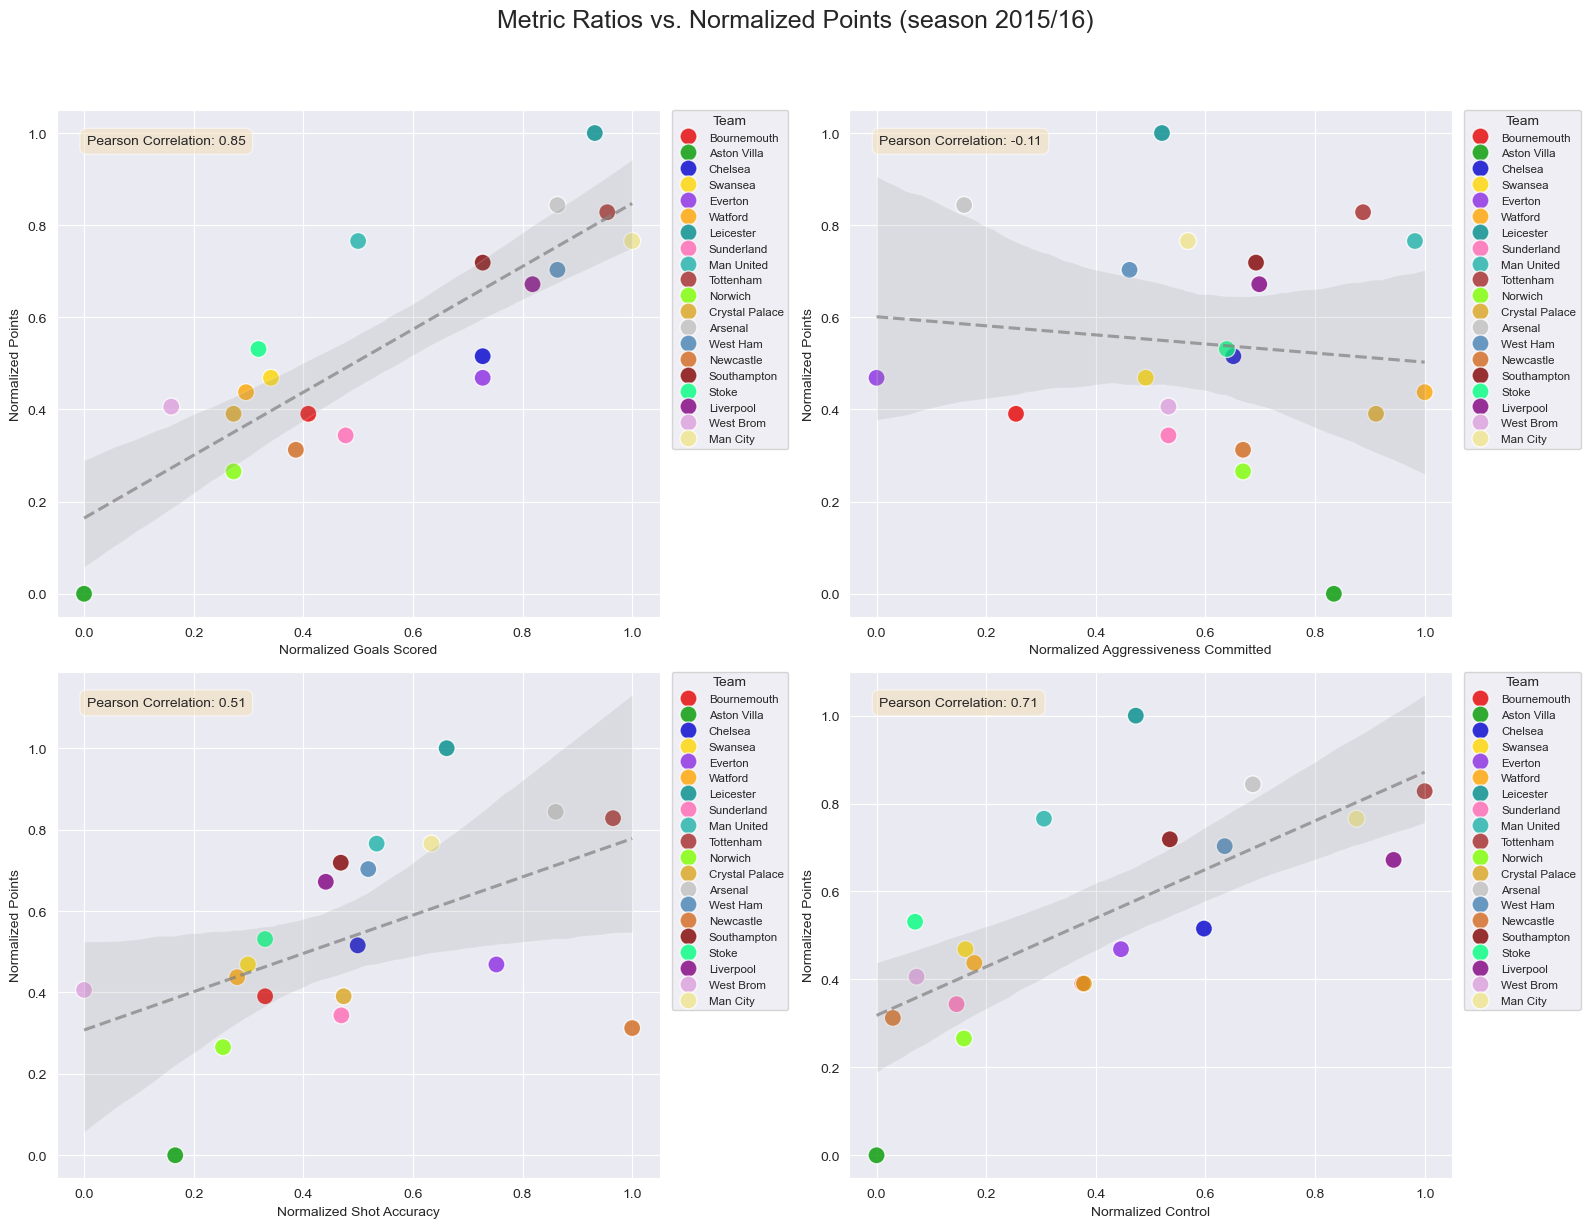


--- EPL Network Analysis Complete ---


In [578]:
# 1. Load the data
csv_file_path = '../data/epl_final.csv' # Adjust path as necessary
epl_df = load_data(csv_file_path)

if epl_df is None:
    print("Data loading failed. Exiting.")


# --- Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ---
print("\n\n#####################################################################")
print("### Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ###")
print("#####################################################################")
perform_epl_network_analysis(
    epl_df=epl_df,
    analysis_season='2015/16',
    metrics_to_analyze=['control', 'aggressiveness'],
    thresholds_for_analysis=[0.2, 0.2],
    keep_above_threshold = False    
)



#####################################################################
### Scenario 2: Multi-Season Analysis (2010-2020) ###
#####################################################################

--- Starting EPL Network Analysis for seasons from 2010/11 to 2020/21 ---
Network created for seasons from 2010/11 to 2020/21 with 37 nodes and 1078 edges.

--- Overall Network Properties (Initial Graph) ---
Number of nodes: 37
Number of edges: 1078
Network Density: 0.8093

--- Calculating Total Team Points across the provided data ---
Top 10 Teams by Total Points:
  Man City: 912 points
  Man United: 814 points
  Chelsea: 797 points
  Liverpool: 793 points
  Tottenham: 761 points
  Arsenal: 761 points
  Everton: 611 points
  West Ham: 471 points
  Newcastle: 455 points
  Southampton: 436 points

--- Starting Unified Centrality and Community Analysis ---

### Analysis for Metric: 'control' ###

--- Calculating Centrality Measures for metric: control (Threshold: 0.4) ---
Applying filter for 'c

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_44974/4262715515.py:43: UserWarning: The palette list has more values (46) than needed (37), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_44974/4262715515.py:43: UserWarning: The palette list has more values (46) than needed (37), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_44974/4262715515.py:43: UserWarning: The palette list has more values (46) than needed (37), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_44974/4262715515.py:43: UserWarning: The palette list has more values (46) than needed (37), which may not be intended.
  sns.scatterplot(


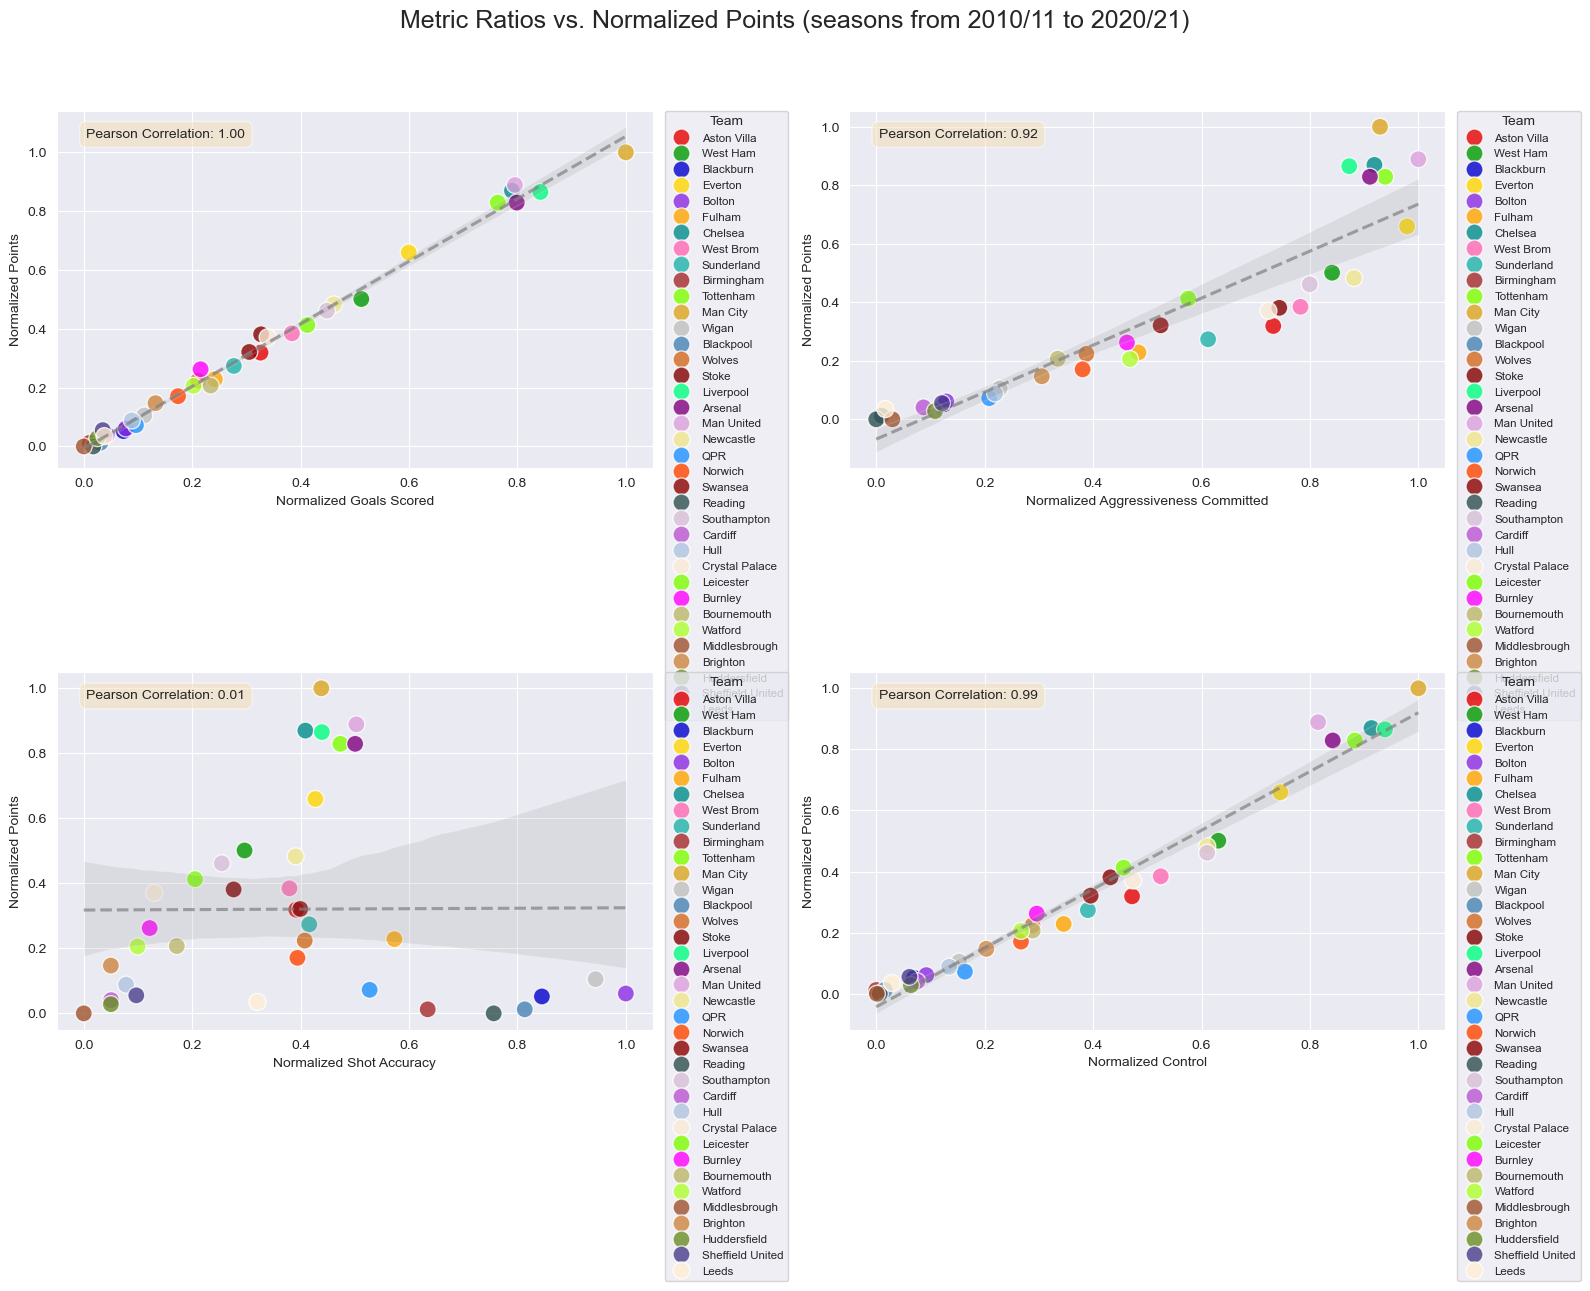


--- EPL Network Analysis Complete ---


In [579]:
# --- Scenario 2: Multi-Season Analysis (2014-2017) on 'aggressiveness', No Normalization, with Filtering ---
print("\n\n#####################################################################")
print("### Scenario 2: Multi-Season Analysis (2010-2020) ###")
print("#####################################################################")
perform_epl_network_analysis(
    epl_df=epl_df,
    network_start_year=2010,
    network_end_year=2020,
    metrics_to_analyze=['control', 'aggressiveness'],
    thresholds_for_analysis=[0.4, 0.4],
    keep_above_threshold = False  
    
)

In [580]:
# Visualize the network for a specific metric (e.g., "goals")
visualize_network(epl_network, selected_season, metric_to_display="goals", file_name=f'network_{selected_season.replace("/", "-")}_goals.png')

NameError: name 'epl_network' is not defined

In [ ]:
# Visualize the network for another metric (e.g., "shot_accuracy"
visualize_network(epl_network, selected_season, metric_to_display="shot_accuracy", file_name=f'network_{selected_season.replace("/", "-")}_shot_accuracy.png')

In [ ]:
# Example of how to access edge data:
print("\nExample edge data (e.g., Arsenal -> a Tottenham team):")
team1_name_example = 'Arsenal'
team2_partial_name_example = 'Tottenham' # We'll search for a team containing this string

actual_team1_name = None
actual_team2_name = None
available_nodes = list(epl_network.nodes())

for node_name in available_nodes:
    if team1_name_example in node_name: # Simple check, might need refinement for exact match
        actual_team1_name = node_name
    if team2_partial_name_example in node_name:
        actual_team2_name = node_name

if actual_team1_name and actual_team2_name and epl_network.has_edge(actual_team1_name, actual_team2_name):
    print(f"Edges from {actual_team1_name} to {actual_team2_name}:")
    # Correct iteration for MultiDiGraph's get_edge_data().items()
    for metric_key, key_dict_val in epl_network.get_edge_data(actual_team1_name, actual_team2_name).items():
         print(f"  Metric: {metric_key}, Weight: {key_dict_val.get('weight', 'N/A'):.2f}")
elif actual_team1_name and actual_team2_name:
    print(f"  No direct edges found from {actual_team1_name} to {actual_team2_name} in the graph for season {selected_season}.")
else:
    print(f"  Could not find one or both teams ('{team1_name_example}', '{team2_partial_name_example}') as nodes in the network for this season.")

Okay, now that your network is created and functioning, we can dive into analyzing it! Network analysis can reveal fascinating structural properties and potential groupings (communities) within the Premier League based on the metrics you've defined.

We'll explore:
1.  **Basic Structural Properties:** A quick look at the overall network.
2.  **Node-Level Centrality Analysis:** Identifying key teams based on different metrics.
3.  **Community Detection:** Discovering groups of teams that are more densely interconnected by certain metrics.

Let's assume your main `MultiDiGraph` is stored in a variable called `epl_network` (or `full_dataset_network` if you analyzed the whole dataset). I'll use `G_multi` as a generic placeholder for the graph object in the functions.

---

## 1. Preparing for Metric-Specific Analysis

Since your main graph is a `MultiDiGraph` (multiple types of edges between nodes), many standard NetworkX analysis functions work best on simpler `DiGraph` (directed) or `Graph` (undirected) instances, typically focusing on one relationship type at a time.

Let's create a helper function to extract a subgraph for a specific metric.


In [ ]:

import networkx as nx
import pandas as pd # For Series in centrality display
import matplotlib.pyplot as plt # For any potential inline plots if needed

def extract_metric_graph(G_multi, metric_key, make_undirected=False, default_weight_for_missing=0):
    """
    Extracts a DiGraph or Graph for a specific metric from a MultiDiGraph.

    Args:
        G_multi (nx.MultiDiGraph): The input multi-directed graph.
        metric_key (str): The key of the metric to extract (e.g., "goals", "control").
        make_undirected (bool): If True, returns an undirected Graph.
                                If False, returns a DiGraph.
        default_weight_for_missing (float): Weight to assign if an edge for the metric_key
                                            is technically present but weight attribute is missing.

    Returns:
        nx.DiGraph or nx.Graph: A graph with only the specified metric's edges.
                                Nodes are preserved.
    """
    if make_undirected:
        H = nx.Graph()
    else:
        H = nx.DiGraph()
    
    H.add_nodes_from(G_multi.nodes()) # Ensure all teams are in the new graph

    for u, v, data in G_multi.edges(data=True):
        if data.get('key') == metric_key:
            weight = data.get('weight', default_weight_for_missing)
            if H.has_edge(u, v):
                # If multiple edges of the same metric_key exist (should not with current create_epl_network)
                # or if converting to undirected and edge u-v already considered from v-u
                if make_undirected:
                     # Simple sum for undirected if edges appear in both directions
                    H[u][v]['weight'] = H[u][v].get('weight', 0) + weight
                else: # Directed, multiple edges of same type not expected by current creation logic
                    H[u][v]['weight'] = max(H[u][v].get('weight', 0), weight) # Or sum, depends on desired logic
            else:
                H.add_edge(u, v, weight=weight)
    return H

# Example of how to use it (assuming 'epl_network' is your created graph)
# G_goals = extract_metric_graph(epl_network, "goals")
# G_control = extract_metric_graph(epl_network, "control")



---

## 2. Structural Network Properties

### Basic Network Density
Network density tells us how many connections exist compared to the maximum possible connections. For `MultiDiGraph`, it's a bit nuanced. We can calculate it for specific metric subgraphs.


In [ ]:

# Assuming epl_network is your MultiDiGraph and you've run the previous cell
# Let's analyze the density of the "goals" interaction graph
G_goals = extract_metric_graph(epl_network, "goals") # Directed graph for goals

if G_goals.number_of_nodes() > 0:
    density_goals = nx.density(G_goals)
    print(f"Density of the 'goals' interaction graph: {density_goals:.4f}")
else:
    print("Graph for 'goals' is empty or not created.")

# What it might mean:
# A higher density in a directed "goals" graph (where an edge A->B means A scored on B)
# would mean that teams tend to score against a larger proportion of other teams.
# In a league where everyone plays everyone, the number of actual directed edges will be n*(n-1).
# The nx.density for DiGraph is m / (n*(n-1)). If all teams scored at least one goal against all others, density would be 1.
# Lower density means scoring is more sparse or selective.



### Interpretation of Density:
The density calculated by `nx.density` for a `DiGraph` is $m / (n(n-1))$, where $m$ is the number of edges and $n$ is the number of nodes. If every team scored against every other team at least once (creating an edge), the density would be 1.0. A lower value indicates that scoring relationships are more sparse.

---

## 3. Node-Level Centrality Analysis (Identifying Key Teams)

Centrality measures help identify the most "important" or "influential" nodes (teams) in the network according to different criteria. We'll look at degree centrality and PageRank, focusing on specific metric subgraphs.

### 3.1. Degree Centrality (In-Degree and Out-Degree)

* **Out-Degree:** For a team, this can represent how many other teams it "acts upon" for a given metric (e.g., scores against, exerts control over).
* **In-Degree:** Represents how many other teams "act upon" it (e.g., score against it, exert control over it).
* **Weighted Degree:** Considers the weights of the edges, giving a measure of the total strength of interaction.

Let's analyze this for the "goals" and "control" metrics.


In [ ]:

def print_top_n_centrality(centrality_dict, metric_name, n=5):
    """Helper function to print top N teams from a centrality dictionary."""
    if not centrality_dict:
        print(f"No {metric_name} centrality data to display.")
        return
    
    sorted_teams = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)
    print(f"\n--- Top {n} teams by {metric_name} ---")
    for i, (team, score) in enumerate(sorted_teams[:n]):
        print(f"{i+1}. {team}: {score:.2f}")

# --- Analysis for "goals" metric ---
# G_goals was created earlier: G_goals = extract_metric_graph(epl_network, "goals")
if 'G_goals' in locals() and G_goals.number_of_nodes() > 0:
    # Out-degree strength for "goals" (Total goals scored by each team)
    goals_scored_strength = dict(G_goals.out_degree(weight='weight'))
    print_top_n_centrality(goals_scored_strength, "'goals' Scored (Weighted Out-Degree)")

    # In-degree strength for "goals" (Total goals conceded by each team)
    goals_conceded_strength = dict(G_goals.in_degree(weight='weight'))
    print_top_n_centrality(goals_conceded_strength, "'goals' Conceded (Weighted In-Degree)")
else:
    print("Skipping 'goals' centrality analysis as G_goals is not properly defined or is empty.")

# --- Analysis for "control" metric ---
G_control = extract_metric_graph(epl_network, "control")
if G_control.number_of_nodes() > 0:
    # Out-degree strength for "control" (Total control exerted by each team)
    control_exerted_strength = dict(G_control.out_degree(weight='weight'))
    print_top_n_centrality(control_exerted_strength, "'control' Exerted (Weighted Out-Degree)")

    # In-degree strength for "control" (Total control received/faced by each team)
    control_faced_strength = dict(G_control.in_degree(weight='weight'))
    print_top_n_centrality(control_faced_strength, "'control' Faced (Weighted In-Degree)")
else:
    print("Skipping 'control' centrality analysis as G_control is not properly defined or is empty.")

# Similarly for "aggressiveness" and "shot_accuracy"
# For "shot_accuracy", you might be interested in the average accuracy (out-degree weight / out-degree count)
# or just the weighted out-degree if you consider higher total weighted accuracy against opponents as better.



### Interpretation of Degree Centrality:

* **Goals Scored (Weighted Out-Degree for "goals"):** Teams ranked high here are prolific scorers against their opponents over the season/dataset. These are likely the top attacking teams.
* **Goals Conceded (Weighted In-Degree for "goals"):** Teams ranked high here have conceded the most goals. These indicate teams with defensive vulnerabilities.
* **Control Exerted (Weighted Out-Degree for "control"):** Teams high on this list dominate their matches more in terms of shots and corners against opponents.
* **Control Faced (Weighted In-Degree for "control"):** Teams high here are often on the receiving end of opponent's territorial dominance.

### 3.2. PageRank Centrality

PageRank (and Eigenvector Centrality) measures the influence of a node by considering the importance of its neighbors. A team is important if it scores against (or controls, etc.) other important/strong teams.


In [ ]:

# --- PageRank for "goals" metric (who scores against strong opponents or teams that concede less) ---
# Note: PageRank on a "goals scored" graph implies that receiving a link means "being scored upon".
# So, a team with high PageRank is one that is frequently scored upon by teams that themselves are scored upon a lot...
# This might be counterintuitive for goals.
# Let's try PageRank on a graph where edges A->B mean A DOMINATES B in terms of goals (e.g. A scored more than average on B)
# Or, more simply, PageRank on the raw "goals scored" graph:
# A high PageRank score for team T means that T is scored against by many teams U,
# especially if those teams U themselves are scored against by many other (potentially "important") teams.
# This interpretation can be tricky.

# Let's consider PageRank on the "control" graph where A->B means A exerts control over B.
# A high PageRank score for team T would mean that T exerts control over teams U,
# where these teams U are themselves influential (i.e., they exert control over many or important other teams).
# This indicates a team that can dominate already dominant teams.

if 'G_control' in locals() and G_control.number_of_nodes() > 0:
    try:
        pagerank_control = nx.pagerank(G_control, weight='weight')
        print_top_n_centrality(pagerank_control, "PageRank on 'control' graph")
    except nx.NetworkXError as e:
        print(f"Could not calculate PageRank for 'control' graph (possibly due to graph structure): {e}")
else:
    print("Skipping PageRank for 'control' as G_control is not properly defined or is empty.")
    
# --- PageRank for "goals" metric ---
# If A->B edge means A scored on B, then teams that get "linked to" (i.e., are scored upon) by 
# teams that score a lot (or score on many others) will get high PageRank.
# This means high PageRank teams are those that are vulnerable to strong attacking teams.
if 'G_goals' in locals() and G_goals.number_of_nodes() > 0:
    try:
        # Invert weights for goals conceded? Or use as is?
        # If weight is goals scored, high pagerank = scored on by influential scorers
        pagerank_goals_conceded_profile = nx.pagerank(G_goals, weight='weight')
        print_top_n_centrality(pagerank_goals_conceded_profile, "PageRank on 'goals' graph (profile of being scored on)")
    except nx.NetworkXError as e:
        print(f"Could not calculate PageRank for 'goals' graph: {e}")
else:
    print("Skipping PageRank for 'goals' as G_goals is not properly defined or is empty.")




### Interpretation of PageRank:

* **PageRank on "control" graph (A exerts control on B):** Teams with high PageRank are those that exert significant control, especially over other teams that are themselves central in the "control" network. These are truly influential teams in terms of game dominance.
* **PageRank on "goals" graph (A scores on B):** This is a bit more complex to interpret directly for "team strength." A team `T` gets a high PageRank if it is scored upon (`U -> T`) by teams `U` that are "important" (meaning `U` scores on many or important teams). So, high PageRank here might indicate teams that are defensively vulnerable to prolific/influential attacking sides.

---

## 4. Community Detection

Community detection algorithms aim to find groups of nodes (teams) that are more densely connected to each other within their group than to nodes outside their group. For this, we usually need an undirected graph.

Let's try to find communities based on the **total control exchanged** between teams.
1.  Extract the "control" graph (A -> B with weight = A's control vs B).
2.  Create an undirected graph where the edge weight between A and B is the sum of (A's control vs B) + (B's control vs A).
3.  Apply the Louvain community detection algorithm.


In [ ]:

# Community detection based on "total control exchanged"
if 'G_control' in locals() and G_control.number_of_nodes() > 0:
    # Create an undirected graph representing total control interaction
    G_control_undirected = nx.Graph()
    G_control_undirected.add_nodes_from(G_control.nodes())

    for u, v, data in G_control.edges(data=True): # Iterate through directed control edges
        weight_uv = data.get('weight', 0)
        # For edge u-v in undirected graph, add weight from u->v
        current_weight = G_control_undirected.get_edge_data(u,v, default={'weight':0})['weight']
        G_control_undirected.add_edge(u, v, weight=current_weight + weight_uv)
        
    # Check if the graph has edges before running community detection
    if G_control_undirected.number_of_edges() > 0:
        print("\n--- Detecting Communities based on 'Total Control Exchanged' ---")
        try:
            # Louvain algorithm requires positive weights if the implementation details matter.
            # Ensure all weights are non-negative; our control metric should be.
            communities_louvain_control = nx.community.louvain_communities(G_control_undirected, weight='weight', seed=42)
            
            print(f"Found {len(communities_louvain_control)} communities for 'Total Control Exchanged':")
            for i, community in enumerate(communities_louvain_control):
                print(f"Community {i+1}: {sorted(list(community))}")
        except Exception as e: # Catch any error during community detection
             print(f"Could not perform Louvain community detection: {e}")
             print("This can happen if the graph has no edges or other structural issues for the algorithm.")
    else:
        print("Undirected 'control' graph has no edges, skipping community detection.")
else:
    print("Skipping community detection for 'control' as G_control is not defined or is empty.")




### Interpretation of Communities (e.g., for "Total Control Exchanged"):

* **Clusters of High Interaction:** Communities might represent groups of teams that have very active "control battles" amongst themselves – meaning the sum of control exerted by A on B and B on A is high within the group.
* **Playing Style Groups:** Potentially, these communities could group teams with similar overall intensity or style regarding territorial dominance (either exerting it or facing it strongly within the community).
* **League Tiers (Hypothetical):** If top teams consistently have high control exchanges only among themselves, and similarly for mid-table or bottom teams, communities might reflect these competitive tiers. This is speculative and depends heavily on the data.

---

### Further Analysis Steps:

* **Thresholding:** For some analyses (especially community detection or visualization), you might want to create graphs where edges only exist if their weight exceeds a certain threshold (e.g., only show "strong" control relationships).
* **Evolution over Seasons:** If you run this analysis for multiple individual seasons, you can track how team centralities and community structures change over time.
* **Combining Metrics:** More advanced analysis could involve creating a weighted graph where edge weights are a composite score from multiple metrics, though this requires careful normalization and weighting of each metric.
* **Statistical Significance:** For community structures or centrality scores, one might consider statistical tests to see if the observed patterns are significant or likely due to chance (more advanced).

This provides a starting point for your structural and community analysis. Remember that the interpretation of these network metrics is key and should always be tied back to the specific meaning of your edge definitions and the context of football!